In [1]:
!pwd

/mnt/d/books/iitm/agentBased/codes/covasim/models/vanilla


In [2]:
import math
from os import listdir
from os.path import isfile, join
from datetime import datetime
import numpy as np
import geopandas as gpd
import pandas as pd
from pyproj import CRS
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [3]:
data_folder = '/mnt/d/books/iitm/agentBased/data/fb/Tamil_Nadu_Coronavirus_Disease_Prevention_Map_Apr_07_2020_Id/2618166339883143_2020-05-03_2020-05-10_csv'

In [4]:
states = gpd.read_file('/mnt/d/books/iitm/agentBased/data/tn/states_shape/Admin2.shp')
tn = states[states.ST_NM == 'Tamil Nadu']

In [5]:
class TileSystem:
    def __init__(self):
        self.earth_radius = 63_78_137
        self.min_latitude = -85.05112878
        self.max_latitude = 85.05112878
        self.min_longitude = -180
        self.max_longitude = 180

    @staticmethod
    def clip(n, min_value, max_value):
        return min(max(n, min_value), max_value)

    def map_size(self, level_of_detail):
        return 256 << level_of_detail

    def ground_resolution(self, latitude, level_of_detail):
        latitude = self.clip(latitude, self.min_latitude, self.max_latitude)
        return np.cos(latitude * np.pi / 180) * 2 * np.pi * self.earth_radius / self.map_size(level_of_detail)
    
    def map_scale(self, latitude, level_of_detail, screen_dpi):
        return self.ground_resolution(latitude, level_of_detail) * screen_dpi / 0.0254
    
    def lat_long_to_pixel(self, latitude, longitude, level_of_detail):
        latitude = self.clip(latitude, self.min_latitude, self.max_latitude)
        longitude = self.clip(longitude, self.min_longitude, self.max_longitude)
        
        x = (longitude + 180) / 360
        sin_latitude = np.sin(latitude * np.pi / 180)
        y = 0.5 - np.log((1 + sin_latitude) / (1 - sin_latitude)) / (4 * np.pi)
        
        map_size = self.map_size(level_of_detail)
        
        pixel_x = int(self.clip(x*map_size + 0.5, 0, map_size-1))
        pixel_y = int(self.clip(y*map_size + 0.5, 0, map_size-1))
        
        return pixel_x, pixel_y
    
    def pixel_to_lat_long(self, pixel_x, pixel_y, level_of_detail):
        map_size = self.map_size(level_of_detail)
        x = (self.clip(pixel_x, 0, map_size-1) / map_size) - 0.5
        y = 0.5 - (self.clip(pixel_y, 0, map_size-1) / map_size)
        
        latitude = 90 - 360*np.arctan(np.exp(-2 * np.pi * y)) / np.pi
        longitude = 360 * x
        
        return latitude, longitude
    
    def pixel_to_tile(self, pixel_x, pixel_y):
        tile_x = int(pixel_x / 256)
        tile_y = int(pixel_y / 256)
        return tile_x, tile_y

    def tile_to_pixel(self, tile_x, tile_y):
        pixel_x = tile_x * 256
        pixel_y = tile_y * 256
        return pixel_x, pixel_y

    def tile_to_quadkey(self, tile_x, tile_y, level_of_detail):
        quadkey = ""
        for i in range(level_of_detail, 0, -1):
            digit = 0
            mask = 1 << (i-1)
            if ((tile_x & mask) != 0):
                digit += 1
            if ((tile_y & mask) != 0):
                digit += 2
            quadkey += str(digit)
        return quadkey
    
    def quadkey_to_tile(self, quadkey):
        tile_x, tile_y = 0, 0
        level_of_detail = len(quadkey)
        for i in range(level_of_detail, 0, -1):
            mask = 1 << (i-1)
            if (quadkey[level_of_detail - i] == '0'):
                continue
            elif (quadkey[level_of_detail - i] == '1'):
                tile_x |= mask
            elif (quadkey[level_of_detail - i] == '2'):
                tile_y |= mask
            elif (quadkey[level_of_detail - i] == '3'):
                tile_x |= mask
                tile_y |= mask
            else:
                raise ValueError(f"Invalid quadkey: {quadkey}")
        return level_of_detail, tile_x, tile_y

In [31]:
ts = TileSystem()
control_level = 9

In [21]:
files = sorted([join(data_folder, f) for f in listdir(data_folder) if isfile(join(data_folder, f))])

In [35]:
quadkeys = set()
for f in files:
    df = pd.read_csv(f)
    df = df[df.country == 'IN']
    quadkeys.update(df.start_quadkey)
    quadkeys.update(df.end_quadkey)
quadkeys = [str(qkey) for qkey in quadkeys]

control_qkeys = list(set([qkey[:control_level] for qkey in quadkeys]))

In [36]:
level, tx, ty = ts.quadkey_to_tile(str(control_qkeys[0]))
px, py = ts.tile_to_pixel(tx, ty)
lat, long = ts.pixel_to_lat_long(px, py, level)
ts.ground_resolution(lat, level) * 256

75971.76465442542

In [25]:
def square_shape(qkey, to=None):
    qkey = str(qkey) if to is None else str(qkey)[:to]
    level, tx, ty = ts.quadkey_to_tile(qkey)
    px, py = ts.tile_to_pixel(tx, ty)
    box = [(px, py), (px+256, py), (px+256, py+256), (px, py+256), (px, py)]
    lats, longs = [], []
    for x, y in box:        
        lat, long = ts.pixel_to_lat_long(x, y, level)
        lats.append(lat); longs.append(long)
    return Polygon(zip(longs, lats))

In [32]:
geometry = [square_shape(qkey, control_level) for qkey in control_qkeys]
qdf = pd.DataFrame({'qkeys': control_qkeys})
tiles = gpd.GeoDataFrame(qdf, crs=CRS("WGS84"), geometry=geometry)

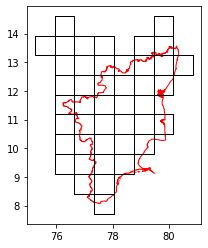

In [33]:
ax = tn.plot(color='white', edgecolor='red')
tiles.plot(ax = ax, color='none', edgecolor='black' )
plt.show()

In [13]:
aoi = gpd.overlay(tiles, tn, how='intersection')

<AxesSubplot:>

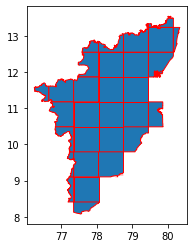

In [14]:
aoi.plot(edgecolor='red')

In [15]:
tn_quadkeys = sorted(aoi.qkeys.to_list())

In [16]:
def binary_search(arr, key, to):
    key = key[:to]
    l, r = 0, len(arr)
    while (l < r):
        mid = l + (r-l)//2
        if (arr[mid] > key):
            r = mid
        else:
            l = mid+1
    idx = l-1
    if (idx < 0 or arr[idx][:to] != key[:to]):
        return -1
    return idx

def get_mobility(files, tn_quadkeys, to):
    n_tiles = len(tn_quadkeys)
    fb_mobility = np.zeros((n_tiles, n_tiles))
    date = None; days = 0;
    for f in files:
        df = pd.read_csv(f)
        new_date = datetime.strptime(df.date_time[0], '%Y-%m-%d %H:%M').date()
        if new_date != date:
            days += 1
            date = new_date
        df = df[df.country == 'IN']
        base = df.n_baseline.to_numpy()
        winsorized_mean = winsorize(base[~np.isnan(base)], [0.1, 0.2]).mean()
        for idx, row in df.iterrows():
            start, end = str(row['start_quadkey']), str(row['end_quadkey'])
            i, j = binary_search(tn_quadkeys, start, to), binary_search(tn_quadkeys, end, to)
            if (i != -1 and j != -1):
                crisis = row['n_crisis']
                if math.isnan(crisis):
                    crisis = winsorized_mean * (1 + float(row['percent_change'])/100)
                fb_mobility[i, j] += float(crisis)
    fb_mobility /= days
    return fb_mobility

In [17]:
mobility = get_mobility(files, tn_quadkeys, to=control_level)

In [18]:
m, n = mobility.shape
for i in range(m):
    for j in range(n):
        if mobility[i, j] == 0:
            mobility[i, j] = 0.5
mobility /= mobility.sum(axis=1)[:, np.newaxis]

In [39]:
diag = np.diag(np.diag(mobility))
k = mobility - diag

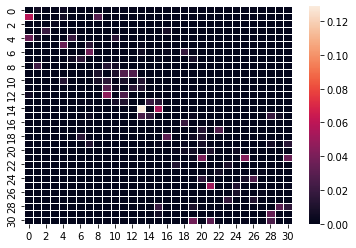

In [40]:
import seaborn as sns

ax = sns.heatmap(k, linewidth=0.5)
plt.show()